# Actor Critic with PPO

There are two main portions to this notebook 
- Gathering trajectories
- Learning from the trajectories

Notebook designed for readability and exploration rather than production. Uses a single GPU. For an industrial-strength PPO in PyTorch check out [ikostrikov's](https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail). For the 'definitive' implementation of PPO, check out [OpenAI baselines](https://github.com/openai/baselines/tree/master/baselines/ppo2) (tensorflow).

Experiments below reproduce results from OpenAI's [procedually-generated environments](https://openai.com/blog/procgen-benchmark/). All hyperparameters taken directly from the [procgen paper](https://arxiv.org/abs/1912.01588). Everything built from scratch unless otherwise noted in effort to gain intuition.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Check for cuda. Can run on CPU if necessary. 


device = 'cpu'

In [10]:
# If no local GPU or want to run multiple notebooks simultaneously, use Google Colab. In that case, have to install procgen

try: 
    from procgen import ProcgenEnv
except: 
    !pip install procgen
    from procgen import ProcgenEnv

In [11]:
# Same thing, for colab.

try:
    from utils import *
    from models import *
except:
    from google.colab import files
    src = list(files.upload().values())[0] # grab files from local and upload to colab
    from utils import *
    from models import *

## Agent
Using "Impala CNN" as referenced in procgen paper. Architecture from [the original IMPALA paper](https://arxiv.org/abs/1802.01561). Basically just a small vanilla resnet (0.3M params)

In [12]:
agent = ImpalaCNN().to(device) # see models.py for architecture
get_n_params(agent)

'0.308 M params'

## Environment

There are 16 procedurally-generated environments to choose from. Goal is to encourage and test ability to generalize rather than overfit to specific game. 

Using [vectorized environments](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html) from OpenAI. Vecenvs are normal envs stacked side by side. They progress "shoulder to shoulder", giving us more variety in our rollouts than a single env could. To change environment simply swap out env_name. Nothing else changes. Currently set to 'easy' setting but also replicated results on 'hard'. To train on 'hard', increase training steps from 25M to 200M and do gradient accumulation of 4 steps to mimic four workers (see below). 

In [13]:
n_envs = 72 # Procgen paper uses 64 but that's the same shape as img size. Prefer unique dims to faciliate debugging.
n_levels = 0 # Zero for all levels
env_name = 'starpilot' 

env = ProcgenEnv(num_envs=n_envs, env_name=env_name, start_level=0, num_levels=n_levels, distribution_mode='easy')
env = VecExtractDictObs(env, "rgb") 
env = VecMonitor(env)
env = VecNormalize(env, ob=False) # normalizing returns, but not the img frames.
#env = VecFrameStack(env, nstack=4) # procgen paper found limited help from framestacking

In [14]:
# Load trained model if you have one

load_pretrained = False

if load_pretrained:
    try:
        agent.load_state_dict(torch.load(env_name+" agent.torch"), strict=False)
        print("Successfully loaded saved model!")
    except:
        print("No model saved yet")

In [15]:
# take random first step in our envs

env.reset()
frame, reward, done, info = env.step(np.array([env.action_space.sample() for _ in range(n_envs)])); 
frame.shape

(72, 64, 64, 3)

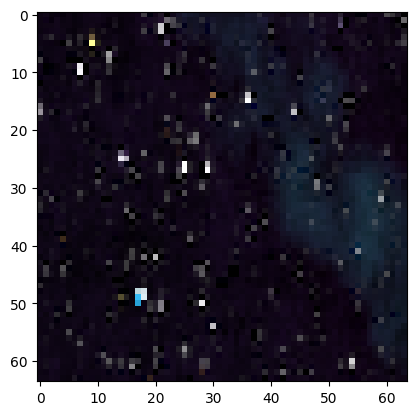

In [16]:
plt.imshow(frame[0])

In [17]:
frame = np_to_pytorch_img(frame).to(device)
frame.shape

torch.Size([72, 3, 64, 64])

In [19]:
# Test out agent and env

with torch.no_grad():
    action_log_probs, state_estimate = agent(frame); 

action_log_probs.shape, state_estimate.shape

(torch.Size([72, 15]), torch.Size([72, 1]))

In [26]:
# Sample an action from the action probs distribution.

get_action(action_log_probs)

tensor([12, 12,  6,  4, 11,  6,  7, 13,  4,  4,  1,  0, 10,  8, 14, 11, 13,  3,
         3, 10, 10,  1, 12, 14,  5,  6, 14,  5,  4,  1,  4,  9, 13,  5,  5,  2,
         2, 13,  7, 11,  8, 14,  7,  2,  3, 13, 10, 10, 11,  7,  0,  7,  1,  3,
         4,  2,  8,  0,  2,  9,  0,  8, 13,  7,  3, 14,  3,  7, 14,  9,  8,  8])

## Calculate Returns

Using [Generalized Advantage Estimation (GAE)](https://arxiv.org/abs/1506.02438). Also have vanilla discounted returns for comparison

In [99]:
# Manually create a mock dataset of rewards to inspect our returns calculators

rewards = np.zeros((32, 5)) # shape mimics 5 envs taking 32 steps. This is like how we'll get it from vecenvs

rewards[10, 1] = 3
rewards[5, 3] = 4
rewards[20, 0] = 5
rewards[31, 0] = 3.66

dones = np.zeros_like(rewards)
dones[5, 1] = 1
dones[15, 3] = 1
dones[20, 0] = 1

In [100]:
def compute_returns(rewards, dones):
    """ Vanilla method of computing discounted returns. Does not use GAE """
    
    GAMMA = .95
    R = []
    r2 = rewards[-1] # this is ~v(s)
    R.append(r2)
    idx = 1
    for i in reversed(range(0, len(rewards)-1)):
        reward = rewards[i]
        r1_is_terminal = (dones[i]-1)*-1 # so Dones are zeros
        r1 = reward + ((r2 * GAMMA)*r1_is_terminal) # If r1 is terminal, don't add in the discounted returns of next state
        print(f"{reward[idx]} + ({r2[idx]} * {GAMMA}) * {r1_is_terminal[idx]}) = {r1[idx]}")
        R.append(r1)
        r2=r1
        
    R.reverse()
    R = np.array(R)
    return R

# Testing 
vanilla_returns = compute_returns(rewards, dones)

0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
3.0 + (0.0 * 0.95) * 1.0) = 3.0
0.0 + (3.0 * 0.95) * 1.0) = 2.8499999999999996
0.0 + (2.8499999999999996 * 0.95) * 1.0) = 2.7074999999999996
0.0 + (2.7074999999999996 * 0.95) * 1.0) = 2.5721249999999993
0.0 + (2.5721249999999993 * 0.95) * 1.0) = 2.443518749999999
0.0 + (2.443518749999999 * 0.95) * -0.0) = 0.0
0.0 + (0.0 * 0.95) * 1.0) = 0.0
0.0 + (0.0 * 0.95

Text(0.5, 1.0, 'Vanilla Returns')

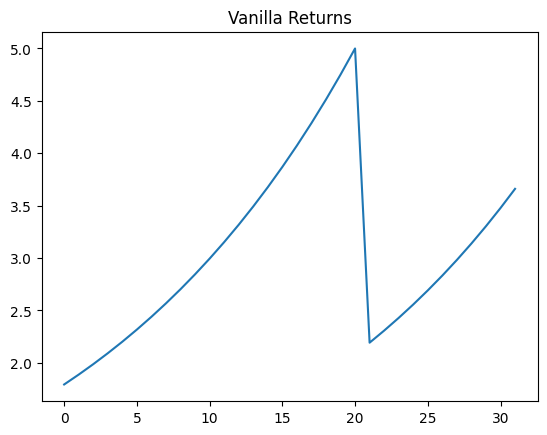

In [101]:
# Using simple discounted returns, here's how our rewards translate into returns.

plt.plot(range(len(vanilla_returns)), [_[0] for _ in vanilla_returns])
plt.title("Vanilla Returns")

In [104]:
def compute_returns_gae(rewards, dones, values):
    """ Compute discounted returns w Generalized Advantage Estimation (GAE) """
    
    GAMMA = .999
    LAM = .95
    lastgaelam = 0
    A = [np.zeros(rewards.shape[-1])]
    for t in reversed(range(0, len(rewards)-1)):
        nextnonterminal = 1.0 - dones[t] # openai baselines records dones in different way. Customized this. Was t+1
        nextvalues = values[t+1]
        delta = rewards[t] + GAMMA * nextvalues * nextnonterminal - values[t]
        lastgaelam = delta * GAMMA * LAM * nextnonterminal * lastgaelam
        A.append(lastgaelam)
    A.reverse()
    A = np.array(A)
    R = A + values
    return R

# Using vanilla returns in place of estimated state values. 
gae_returns = compute_returns_gae(rewards, dones, vanilla_returns);

Text(0.5, 1.0, 'GAE Returns')

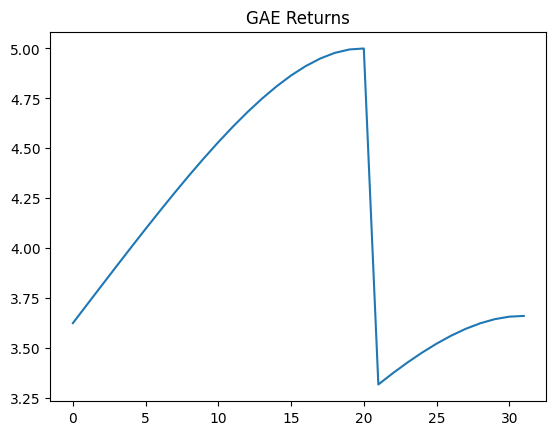

In [105]:
# Test GAE returns w same rewards as above. The difference btwn vanilla and GAE returns won't always look like this. 

plt.plot(range(len(gae_returns)), [_[0] for _ in gae_returns])
plt.title("GAE Returns")

## Gather Trajectories 

In [106]:
# Initialize w first frames

last_frame_ = env.reset()
last_frame_.shape #(n_envs, height, width, channels)

(72, 64, 64, 3)

In [109]:
# Gather trajectories for n_steps. Vecenvs call reset at the end of a game so we can just keep playing and playing...

n_steps = 256

def gather_trajectories():
    with torch.no_grad():
        agent.eval()
        global last_frame_
        frame = last_frame_
        frames_, rewards_, dones_, actions_, old_action_probs_, old_state_estimates_, epinfos = [], [], [], [], [], [], []
        
        for s in range(n_steps):
            frames_.append(frame);
            action_probs, state_estimate = agent(np_to_pytorch_img(frame).to(device));
            action = get_action(action_probs).cpu().numpy();
            frame, reward, done, info = env.step(action)
            rewards_.append(reward); dones_.append(done); actions_.append(action); old_action_probs_.append(action_probs.detach().cpu().numpy()); old_state_estimates_.append(state_estimate.detach().cpu().numpy())

            for i in info:
                episode_info = i.get('episode')
                if episode_info: epinfos.append(episode_info)

        rewards_ = np.array(rewards_); dones_ = np.array(dones_); actions_ = np.array(actions_); frames_ = np.array(frames_); old_state_estimates_ = np.array(old_state_estimates_);
        
        last_frame_ = frames_[-1] # reset global last frame. Next time we gather trajectories we'll pick up here
        
        rewards_[-1] = state_estimate.squeeze(-1).cpu().numpy() # Bootstrapped returns

        returns_ = compute_returns_gae(rewards_, dones_, old_state_estimates_.squeeze(-1))
        
        # Reshaping dims and prepping tensor types and locations. Nothing conceptually interesting.
        returns_, old_state_estimates_, old_action_probs_, actions_, frames_ = reshaping_processing_acrobatics(returns_, old_state_estimates_, old_action_probs_, actions_, frames_)

        return returns_, frames_, actions_, old_action_probs_, old_state_estimates_, epinfos

In [108]:
# Setting global database of rollouts

returns, frames, actions, old_action_probs, old_state_estimates, epinfos = gather_trajectories()
returns.shape, frames.shape, actions.shape

(torch.Size([18432]), torch.Size([18432, 3, 64, 64]), torch.Size([18432]))

In [110]:
# Grabbing scores in real-time during training. Procgen has so many random seeds we can
# train and test on all of them without worrying about overlap btwn train and validate. 

get_avg_score(epinfos)

1.2440192

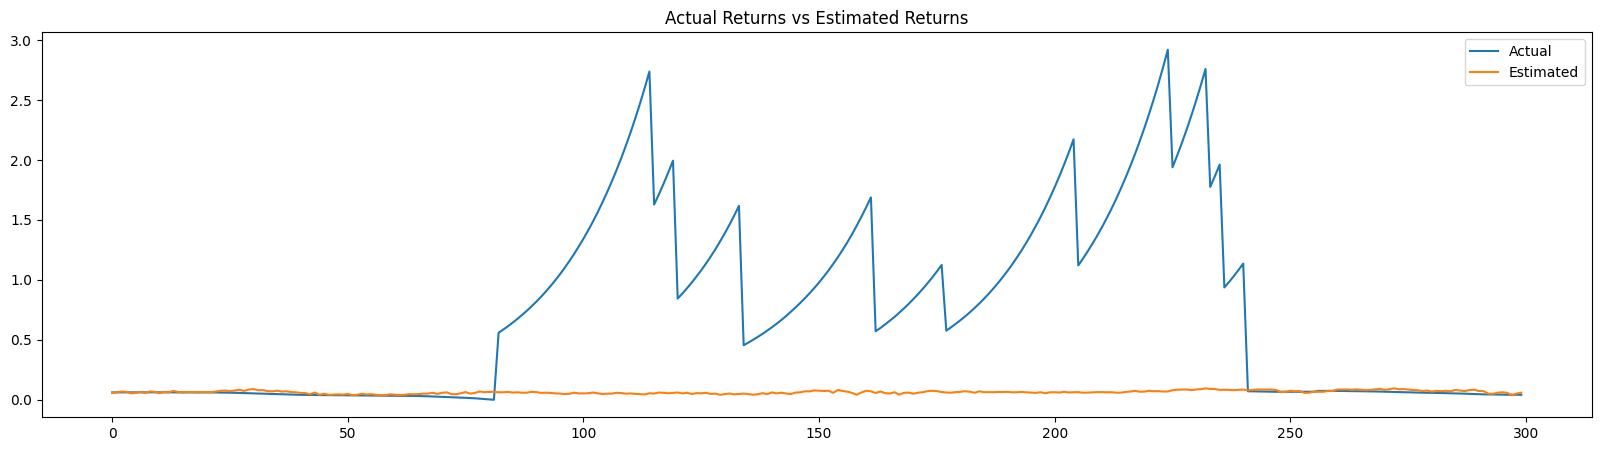

In [122]:
# How good is our critic?

plt.figure(figsize=(20,5))
plt.plot(range(len(returns[:300])), returns[:300])
plt.plot(range(len(old_state_estimates[:300])), old_state_estimates[:300])
plt.title("Actual Returns vs Estimated Returns")
plt.legend(["Actual", "Estimated"])

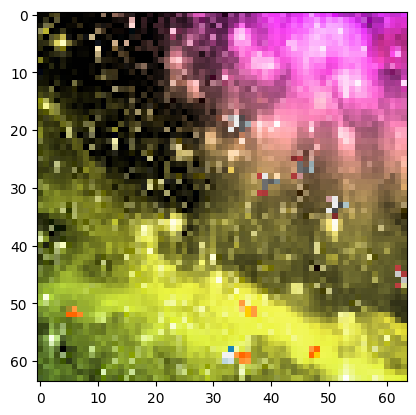

In [120]:
# Check random imgs from rollouts database, ensure processing didn't mess anything up

ix = random.randint(0, len(frames)-1)
plt.imshow(pytorch_to_np_img(frames[ix:ix+1]).squeeze(0))

## Training

When authors say PPO they're ostensibly refering to [the original PPO paper](https://arxiv.org/abs/1707.06347). The trick described in the paper is to prevent the action probabilities generated by your current agent from deviating too far from the the probabilities generated by the agent who actually gathered the data. Paper does this simply by clipping the probabilities to a certain range, usually 20%.

But what people REALLY mean when they say PPO is the above trick [combined with half a dozen others](https://arxiv.org/abs/1811.02553)--each one of which is critical to training success. "PPO" is better described as "the basket of tricks used in actual code implementations like OpenAI Baselines". 

In [123]:
def get_batch(batch_ix):
    return frames[batch_ix].to(device), returns[batch_ix].to(device), actions[batch_ix].to(device), old_action_probs[batch_ix].to(device), old_state_estimates[batch_ix].to(device)

ix = torch.randperm(len(returns))[:5];
frames_batch, returns_batch, actions_batch, old_action_probs_batch, old_state_estimates_batch = get_batch(ix); 
frames_batch.shape, returns_batch.shape, actions_batch.shape, old_action_probs_batch.shape, old_state_estimates_batch.shape

(torch.Size([5, 3, 64, 64]),
 torch.Size([5]),
 torch.Size([5]),
 torch.Size([5, 15]),
 torch.Size([5]))

In [124]:
# Sample img as the agent will see it. Always check inputs as they are directly before agent ingestion

frames_batch[0]

tensor([[[0.0627, 0.0627, 0.0627,  ..., 0.3098, 0.3098, 0.3098],
         [0.0627, 0.0627, 0.0627,  ..., 0.3098, 0.3098, 0.3098],
         [0.0627, 0.0627, 0.0627,  ..., 0.3098, 0.3098, 0.3098],
         ...,
         [0.0627, 0.0627, 0.0627,  ..., 0.1333, 0.1333, 0.0627],
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.1333],
         [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.1333, 0.0627]],

        [[0.0275, 0.0275, 0.0275,  ..., 0.1686, 0.1686, 0.1686],
         [0.0275, 0.0275, 0.0275,  ..., 0.1686, 0.1686, 0.1686],
         [0.0275, 0.0275, 0.0275,  ..., 0.1686, 0.1686, 0.1686],
         ...,
         [0.0275, 0.0275, 0.0275,  ..., 0.0667, 0.0667, 0.0275],
         [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0275, 0.0667],
         [0.0275, 0.0275, 0.0275,  ..., 0.0275, 0.0667, 0.0275]],

        [[0.0627, 0.0627, 0.0627,  ..., 0.2157, 0.2157, 0.2157],
         [0.0627, 0.0627, 0.0627,  ..., 0.2157, 0.2157, 0.2157],
         [0.0627, 0.0627, 0.0627,  ..., 0.2157, 0.2157, 0.

In [125]:
def calculate_action_gain_ppo(action_probs, old_action_probs, actions_taken, advantages, verbose=False):
    """ Actions resulting in positive advantage made more probable, and vice versa. Do not allow to differ from old
    probs by too much. Log probs are from current agent. Actions_taken are from OLD version of agent. """
    
    a = actions_taken.unsqueeze(-1).to(device)
    if verbose: print("\n\nactions unsqueezed\n", a)
        
    chosen_action_probs = action_probs.gather(1, a)
    chosen_action_probs = chosen_action_probs.squeeze(-1)
    
    old_chosen_action_probs = old_action_probs.gather(1, a)
    old_chosen_action_probs = old_chosen_action_probs.squeeze(-1)
    if verbose: print("\n\nchosen action probs, new and old\n", chosen_action_probs,'\n', old_chosen_action_probs, '\n\nadvantages values', advantages)
    
    ratio = torch.exp(chosen_action_probs - old_chosen_action_probs)
    if verbose: print('\n\nratio', ratio)
    
    unclipped_action_gain = ratio * advantages
    clipped_action_gain = torch.clamp(ratio, .8, 1.2) * advantages
    if verbose: print('\n\nunclipped and clipped action gains\n', unclipped_action_gain, '\n', clipped_action_gain)
    
    action_gain = torch.min(unclipped_action_gain, clipped_action_gain)
    if verbose: print('\n\n conservative lower bound action gain\n', action_gain)
        
    action_gain = action_gain.mean()
    if verbose: print('\n\nmean', action_gain)
        
    return action_gain # single scalar

In [126]:
with torch.no_grad():
    action_probs, state_estimates = agent(frames_batch); 

action_probs.shape # (bs, n_actions)

torch.Size([5, 15])

In [127]:
# Test action gain calculations. Verbose true to inspect actual values.

calculate_action_gain_ppo(action_probs, old_action_probs_batch, actions_batch, returns_batch, verbose=False)

tensor(3.4754)

In [128]:
def get_critic_loss(old_state_estimates_b, state_estimates, returns_b, verbose=False):
    """ How good is critic at estimating state? Don't allow to differ too much from old state estimates """
    
    state_estimates = state_estimates.squeeze(-1)
    clipped_state_estimate = old_state_estimates_b + torch.clamp(state_estimates - old_state_estimates_b, -.2, .2)
    if verbose: print("\nstate estimates, new and old\n\n", state_estimates, '\n', old_state_estimates_b, '\n\nreturns', returns_b)
    critic_loss_1 = ((returns_b - clipped_state_estimate)**2)
    critic_loss_2 = ((returns_b - state_estimates)**2)
    critic_loss = torch.max(critic_loss_1, critic_loss_2)
    if verbose: print('\nCritic Losses: clipped, unclipped, conservative:\n', critic_loss_1, '\n', critic_loss_2, '\n', critic_loss)
    critic_loss = critic_loss.mean() * .5
    return critic_loss # single scalar

get_critic_loss(old_state_estimates_batch, state_estimates, returns_batch, False) # verbose true to inspect actual values

tensor(28.3634)

In [129]:
def get_entropy_bonus(action_probs):
    """ Encourage humility """
    e = -(action_probs.exp() * (action_probs+1e-8))
    e = e.sum(dim=1)
    e = e.mean()
    return e

In [130]:
# Pytorch distributions have entropy calc directly out of the box. Check against that.

get_entropy_bonus(action_probs), categorical(action_probs.exp()).entropy().mean()

(tensor(2.7081), tensor(2.7081))

In [132]:
def run_batch(batch_ix, verbose=False):
    """ 
    Run a single batch of data. Takes in indices, uses them to pull from global database of rollouts,
    calculates and returns losses. No gradient steps here. 
    """
    
    frames_b, returns_b, actions_taken_b, old_action_probs_b, old_state_estimates_b = get_batch(batch_ix)

    action_probs, state_estimates = agent(frames_b)
    
    entropy_bonus = get_entropy_bonus(action_probs)
    
    critic_loss = get_critic_loss(old_state_estimates_b, state_estimates, returns_b, verbose=verbose)
    
    with torch.no_grad():
        advantages = (returns_b - state_estimates.squeeze(-1).detach()) # don't want to propogate gradients through this
        advantages -= advantages.mean()
        advantages /= (advantages.std() + 1e-8)
    
    action_gain = calculate_action_gain_ppo(action_probs, old_action_probs_b, actions_taken_b, advantages, verbose=verbose)
    
    return entropy_bonus, action_gain, critic_loss

In [133]:
# Manually run a batch

with torch.no_grad():
    run_batch(ix, False)

In [134]:
# Hyperparameters all taken from procgen paper

lr = 5e-4 # High lr bc batch size is big as well.
opt = torch.optim.Adam(agent.parameters(), lr=lr, eps=1e-5)
n_obs_per_round = n_envs * n_steps; 
target_n_obs = 10_000_000 # This is for 'easy' mode. 'Hard' requires 10x more. This is < half what procgen paper does, but is already enough to begin to converge. 
n_minibatches = 8
bs = n_obs_per_round // n_minibatches
n_rounds = target_n_obs // n_obs_per_round

# procgen paper avgs gradients across 4 workers for training in 'hard' setting. This is same as making bs 4 times bigger. 
# For the same effect on a single GPU, use gradient accumulation to mimic larger batch size. medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255
accumulation_steps = 1 

entropy_coef = .01
value_loss_coef = .5
n_opt_epochs = 3 # how many times does agent 'see' an observation before we discard it?

n_obs_per_round, n_rounds, bs

(18432, 542, 2304)

In [136]:
def reflect(verbose=False):
    """ Learn from current database of rollouts for a single epoch """
    
    agent.train()
    epoch_losses = []
    ix_range = range(len(returns))
    ix = 0
    grad_accum_counter = 1
    while ix < len(returns):
        batch_ix = ix_range[ix:ix+bs]; ix += bs
        entropy_bonus, action_gain, critic_loss = run_batch(batch_ix, verbose=verbose)
        entropy_bonus *= entropy_coef
        critic_loss *= value_loss_coef
        if verbose: print("\n\nentropy bonus, action gain\n, critic loss\n", entropy_bonus.item(), action_gain.item(), critic_loss.item())
        total_loss = critic_loss - entropy_bonus - action_gain
        total_loss /= accumulation_steps
        total_loss.backward()
                
        if grad_accum_counter % accumulation_steps == 0:
            nn.utils.clip_grad_norm_(agent.parameters(), .5);
            opt.step()
            opt.zero_grad()
        grad_accum_counter+=1
        epoch_losses.append(total_loss.item())

    return np.array(epoch_losses).mean(); # epoch avg loss

reflect(True)


state estimates, new and old

 tensor([-0.3599, -0.5154, -0.4203,  ...,  0.0163, -0.4633, -0.0690],
       grad_fn=<SqueezeBackward1>) 
 tensor([0.0567, 0.0616, 0.0687,  ..., 0.0577, 0.0513, 0.0534]) 

returns tensor([0.0618, 0.0618, 0.0615,  ..., 0.0532, 0.0534, 0.0534])

Critic Losses: clipped, unclipped, conservative:
 tensor([0.0421, 0.0401, 0.0372,  ..., 0.0014, 0.0408, 0.0150],
       grad_fn=<PowBackward0>) 
 tensor([0.1778, 0.3332, 0.2322,  ..., 0.0014, 0.2669, 0.0150],
       grad_fn=<PowBackward0>) 
 tensor([0.1778, 0.3332, 0.2322,  ..., 0.0014, 0.2669, 0.0150],
       grad_fn=<MaximumBackward0>)


actions unsqueezed
 tensor([[ 9],
        [12],
        [11],
        ...,
        [13],
        [ 0],
        [14]])


chosen action probs, new and old
 tensor([-2.7474, -2.7328, -2.7546,  ..., -2.7761, -2.6798, -2.6539],
       grad_fn=<SqueezeBackward1>) 
 tensor([-2.7082, -2.7078, -2.7081,  ..., -2.7078, -2.7084, -2.7077]) 

advantages values tensor([-0.3372, -0.2220, -0.2926,

0.48010795563459396

In [137]:
def shuffle_database():
    """ Shuffle the global database of rollouts in place. Doesn't return anything. Requires that database exist. """
    
    global returns, frames, actions, old_action_probs, old_state_estimates
    dataset_ix = torch.randperm(len(returns));
    returns = returns[dataset_ix]
    frames = frames[dataset_ix]
    actions = actions[dataset_ix]
    old_action_probs = old_action_probs[dataset_ix]
    old_state_estimates = old_state_estimates[dataset_ix]

In [ ]:
# Train. 'Easy' mode takes ~3 hours on single GPU. Go outside for a run.

scores = []; losses = [];

for i in range(n_rounds):
    with torch.no_grad():
        returns, frames, actions, old_action_probs, old_state_estimates, epinfos = gather_trajectories() # refresh 'database'
        avg_score = get_avg_score(epinfos)
        scores.append(avg_score)
    
    for e in range(n_opt_epochs):
        shuffle_database()
        loss = reflect(verbose = False)
        losses.append(loss)
    
    if i % 100 == 0: print(i, avg_score)

0 1.5168067


In [ ]:
torch.save(agent.state_dict(), env_name +" agent.torch")

In [ ]:
plt.plot(range(len(scores)), scores)
plt.title("Scores " + env_name)

## Manually Inspect Performance

In [40]:
# Generate some fresh data

with torch.no_grad():
    returns, frames, actions, old_action_probs, old_state_estimates, epinfos = gather_trajectories()
    
returns.shape, frames.shape

(torch.Size([18432]), torch.Size([18432, 3, 64, 64]))

In [41]:
n_vid_steps = 1000

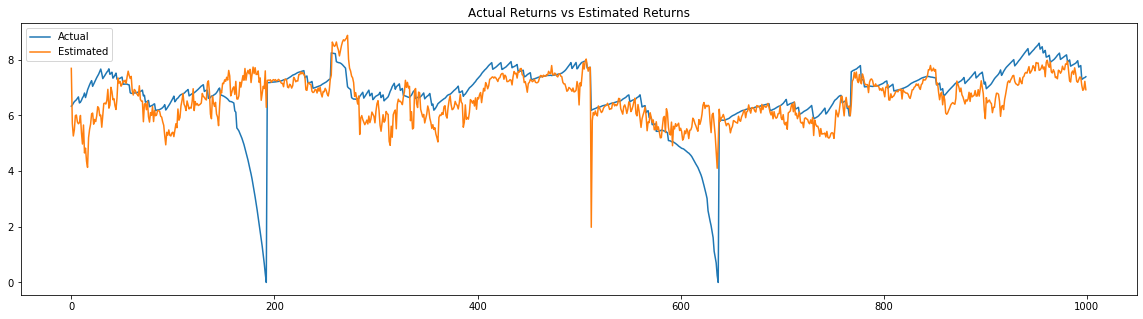

In [42]:
plt.figure(figsize=(20,5))
plt.plot(range(len(returns[:n_vid_steps])), returns[:n_vid_steps])
plt.plot(range(len(returns[:n_vid_steps])), old_state_estimates[:n_vid_steps])
plt.title("Actual Returns vs Estimated Returns")
plt.legend(["Actual", "Estimated"])

In [43]:
# Make a video so we can watch the agent play. Always do this.

frames_np = frames[:n_vid_steps].numpy()
returns_vid = returns[:n_vid_steps]; returns_vid -= returns_vid.min(); returns_vid /= returns_vid.max()

height , width , layers =  64,64,3
fps = 14
video = cv2.VideoWriter(env_name + '_agent_run.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(n_vid_steps):
    f = frames_np[i];
    f = np.transpose(f, (1, 2, 0)) # prep axis numpy style
    f = np.uint8(f*255)
    r = returns_vid[i];
    
    # Adding a square in top-left to display actual returns. White is highest returns, black is lowest.
    f[:5, :5, :] = 255 * r 
    
    video.write(f)

cv2.destroyAllWindows()
video.release()

# Video is now in root directory. If in colab, can download video with colab files functionality